In [2]:
# Load the Titanic dataset, perform basic cleaning, and start EDA with visuals
# - Read the provided combined_titanic.csv
# - Show head and basic summary
# - Clean key columns (types, missing values)
# - Plot initial distributions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Load
titanic_df = pd.read_csv('C:/Users/hp/Downloads/combined_titanic.csv', encoding='ascii')

# 2) Basic inspect
print(titanic_df.head())
print(titanic_df.describe(include='all'))

# 3) Coerce numeric types where applicable
for col in ['Age','Fare','Pclass','SibSp','Parch','Survived']:
    if col in titanic_df.columns:
        titanic_df[col] = pd.to_numeric(titanic_df[col], errors='coerce')

# 4) Quick missingness overview
missing_pct = titanic_df.isna().mean().sort_values(ascending=False)
print(missing_pct.head(15))

# 5) Simple imputation strategy for EDA (do not overwrite source logic):
#    - Age: median by Sex and Pclass when available, else global median
age_fill = titanic_df.groupby(['Sex','Pclass'])['Age'].transform('median')
age_global = titanic_df['Age'].median()
age_fill = age_fill.fillna(age_global)

titanic_df['Age_filled'] = titanic_df['Age'].fillna(age_fill)

#    - Embarked: mode
if 'Embarked' in titanic_df.columns:
    embarked_mode = titanic_df['Embarked'].mode(dropna=True)
    embarked_fill_val = embarked_mode.iloc[0] if len(embarked_mode) > 0 else 'S'
    titanic_df['Embarked_filled'] = titanic_df['Embarked'].fillna(embarked_fill_val)

#    - Fare: median by Pclass
fare_fill = titanic_df.groupby('Pclass')['Fare'].transform('median')
fare_global = titanic_df['Fare'].median()
fare_fill = fare_fill.fillna(fare_global)

titanic_df['Fare_filled'] = titanic_df['Fare'].fillna(fare_fill)


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
  

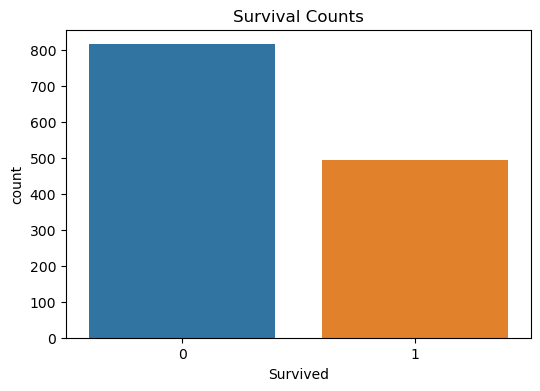

In [3]:
plt.figure(figsize=(6,4))
sns.countplot(data=titanic_df, x='Survived')
plt.title('Survival Counts')
plt.show()

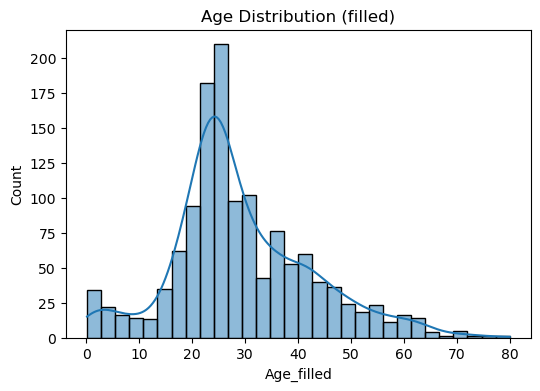

In [4]:
plt.figure(figsize=(6,4))
sns.histplot(titanic_df['Age_filled'], bins=30, kde=True)
plt.title('Age Distribution (filled)')
plt.show()

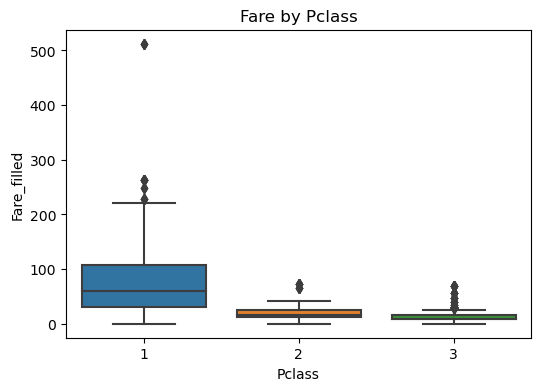

In [5]:
plt.figure(figsize=(6,4))
sns.boxplot(data=titanic_df, x='Pclass', y='Fare_filled')
plt.title('Fare by Pclass')
plt.show()

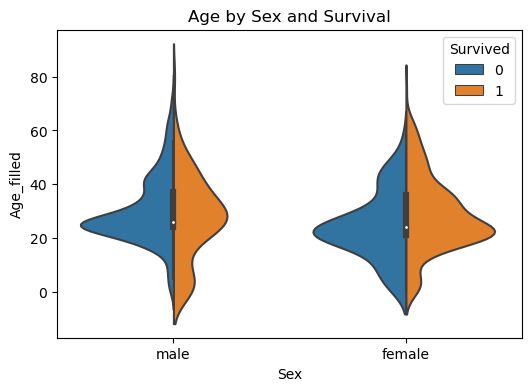

In [6]:
plt.figure(figsize=(6,4))
sns.violinplot(data=titanic_df, x='Sex', y='Age_filled', hue='Survived', split=True)
plt.title('Age by Sex and Survival')
plt.show()

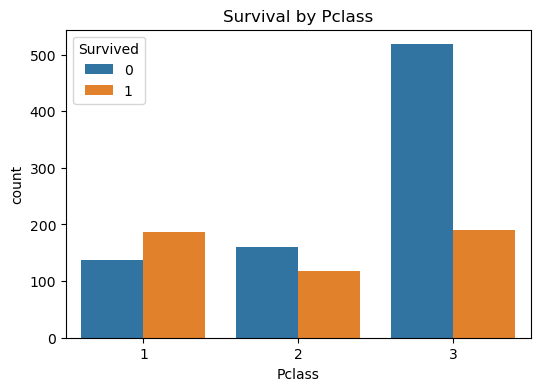

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(data=titanic_df, x='Pclass', hue='Survived')
plt.title('Survival by Pclass')
plt.show()

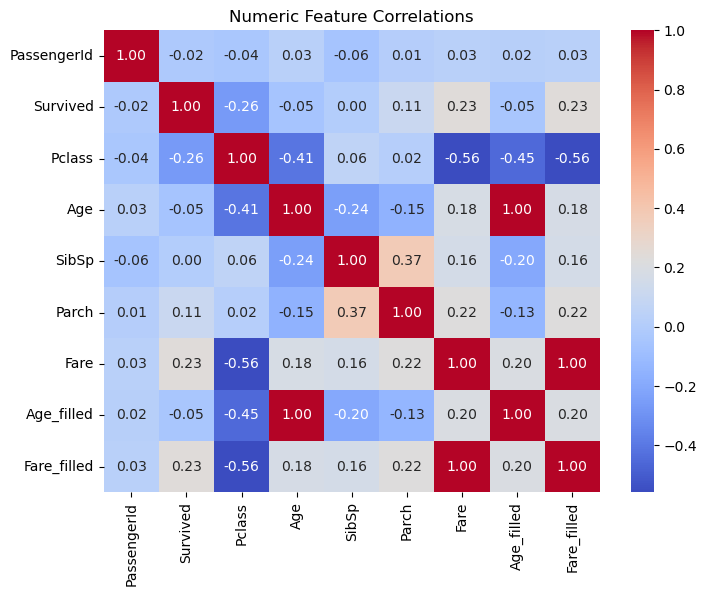

Loaded, cleaned key columns, created filled features, and plotted initial EDA visuals.


In [8]:
# 7) Correlation heatmap for numeric variables
num_cols = titanic_df.select_dtypes(include=[np.number])
plt.figure(figsize=(8,6))
sns.heatmap(num_cols.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Numeric Feature Correlations')
plt.show()

print('Loaded, cleaned key columns, created filled features, and plotted initial EDA visuals.')

              AgeGroup  SurvivalRate
0         Child (0-12)      0.553191
1         Teen (13-18)      0.424242
2  Young Adult (19-30)      0.328125
3        Adult (31-45)      0.404984
4      Mid-age (46-60)      0.418033


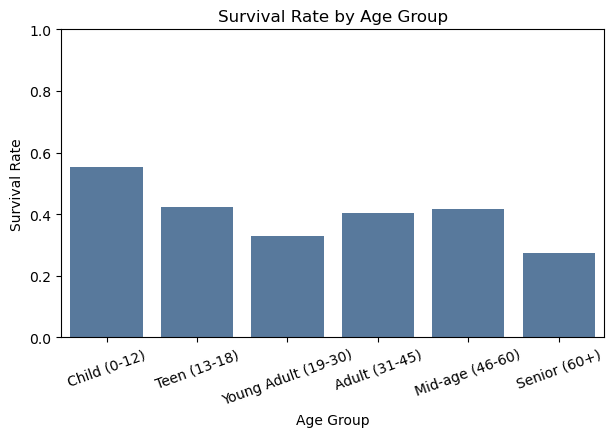

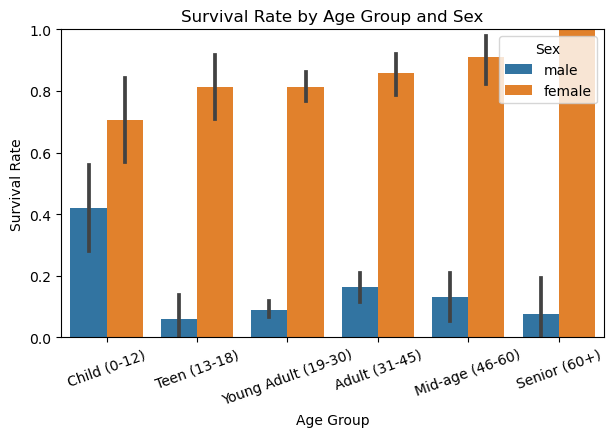

Computed survival rates by age group and plotted overall and by sex.


In [9]:
# Create age groups and compare survival rates across them with visuals
# - Bin Age_filled into bands and compute survival rate per band
# - Show head of the grouped rates and plot bar/line chart
# Ensure the dataframe exists from previous step; if not, load it
try:
    titanic_df
except NameError:
    titanic_df = pd.read_csv('combined_titanic.csv', encoding='ascii')
    titanic_df['Age'] = pd.to_numeric(titanic_df['Age'], errors='coerce')
    titanic_df['Pclass'] = pd.to_numeric(titanic_df['Pclass'], errors='coerce')
    # Simple fill for Age
    age_global = titanic_df['Age'].median()
    titanic_df['Age_filled'] = titanic_df['Age'].fillna(age_global)

# Define age bins
bins = [0, 12, 18, 30, 45, 60, np.inf]
labels = ['Child (0-12)','Teen (13-18)','Young Adult (19-30)','Adult (31-45)','Mid-age (46-60)','Senior (60+)']

age_group_col = 'AgeGroup'
titanic_df[age_group_col] = pd.cut(titanic_df['Age_filled'], bins=bins, labels=labels, right=True, include_lowest=True)

# Compute survival rates
survival_by_agegrp = titanic_df.groupby(age_group_col)['Survived'].mean().reset_index(name='SurvivalRate')

print(survival_by_agegrp.head())

# Plot bar chart of survival rate by age group
plt.figure(figsize=(7,4))
sns.barplot(data=survival_by_agegrp, x=age_group_col, y='SurvivalRate', color='#4C78A8')
plt.ylim(0,1)
plt.title('Survival Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Survival Rate')
plt.xticks(rotation=20)
plt.show()

# Plot survival by age group further broken down by Sex
plt.figure(figsize=(7,4))
sns.barplot(data=titanic_df, x=age_group_col, y='Survived', hue='Sex', estimator=np.mean)
plt.ylim(0,1)
plt.title('Survival Rate by Age Group and Sex')
plt.xlabel('Age Group')
plt.ylabel('Survival Rate')
plt.xticks(rotation=20)
plt.show()

print('Computed survival rates by age group and plotted overall and by sex.')

      Sex  SurvivalRate
0  female       0.82618
1    male       0.12930
   Pclass  SurvivalRate
0       1      0.575851
1       2      0.422383
2       3      0.269394
  Embarked  SurvivalRate
0        C      0.492593
1        Q      0.439024
2        S      0.333698
   SibSp  SurvivalRate
0      0      0.334456
1      1      0.520376
2      2      0.452381
3      3      0.250000
4      4      0.181818
   Parch  SurvivalRate
0      0      0.331337
1      1      0.547059
2      2      0.530973
3      3      0.625000
4      4      0.333333
   FamilySize  SurvivalRate
0           1      0.292405
1           2      0.531915
2           3      0.559748
3           4      0.720930
4           5      0.227273
   IsAlone  SurvivalRate
0        0      0.506744
1        1      0.292405
             FareBin  SurvivalRate
0    (-0.001, 7.896]      0.219585
1    (7.896, 14.454]      0.292835
2   (14.454, 31.275]      0.432927
3  (31.275, 512.329]      0.569659


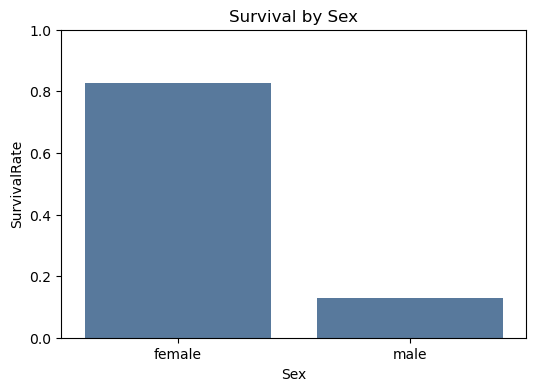

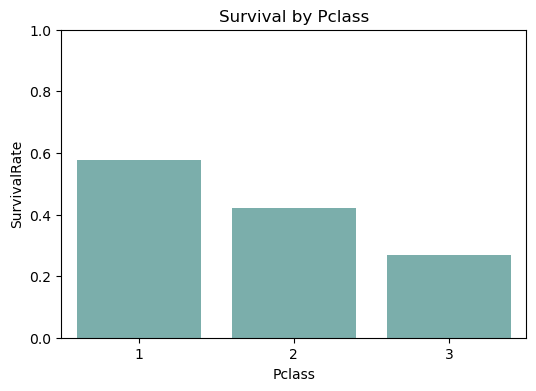

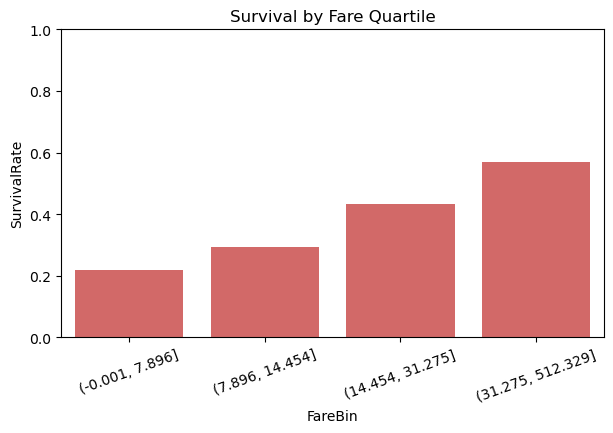

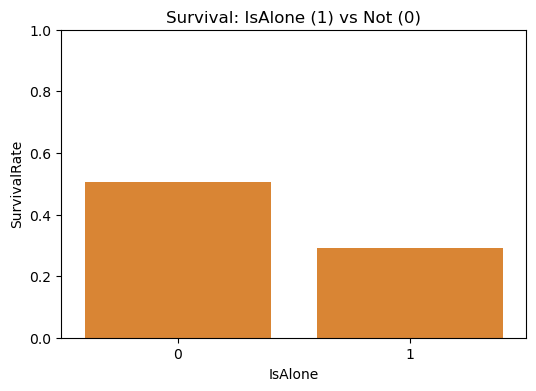

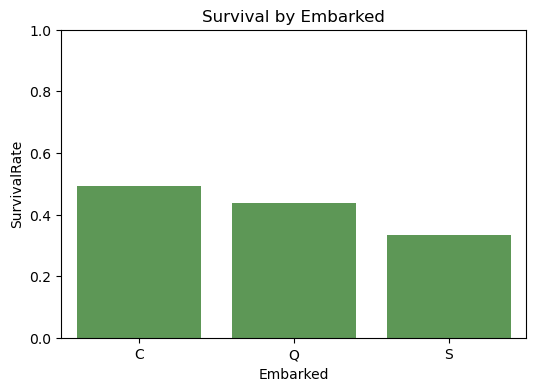

Computed grouped survival rates and plotted key modifying variables.


In [10]:
# Explore which variables modify survival using grouped rates and simple visualizations
# - Analyze Pclass, Sex, SibSp, Parch, Embarked, Fare (binned), Family features
# - Show small heads of summary tables and key plots
# Ensure core fields exist
if 'Age_filled' not in titanic_df.columns:
    titanic_df['Age'] = pd.to_numeric(titanic_df['Age'], errors='coerce')
    titanic_df['Age_filled'] = titanic_df['Age'].fillna(titanic_df['Age'].median())

# Create FamilySize and IsAlone
if 'SibSp' in titanic_df.columns and 'Parch' in titanic_df.columns:
    titanic_df['FamilySize'] = titanic_df['SibSp'].fillna(0) + titanic_df['Parch'].fillna(0) + 1
    titanic_df['IsAlone'] = (titanic_df['FamilySize'] == 1).astype(int)

# Bin Fare for visualization
if 'Fare' in titanic_df.columns:
    titanic_df['Fare_filled'] = pd.to_numeric(titanic_df['Fare'], errors='coerce').fillna(titanic_df['Fare'].median())
    titanic_df['FareBin'] = pd.qcut(titanic_df['Fare_filled'], q=4, duplicates='drop')

# Grouped survival rates
mods = {}
for col in ['Sex','Pclass','Embarked','SibSp','Parch','FamilySize','IsAlone','FareBin']:
    if col in titanic_df.columns:
        grp = titanic_df.groupby(col)['Survived'].mean().reset_index(name='SurvivalRate')
        mods[col] = grp

# Print small samples
for k, dfk in mods.items():
    print(dfk.head())

# Visuals: Survival by key modifiers
plt.figure(figsize=(6,4))
sns.barplot(data=mods['Sex'], x='Sex', y='SurvivalRate', color='#4C78A8')
plt.ylim(0,1)
plt.title('Survival by Sex')
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(data=mods['Pclass'], x='Pclass', y='SurvivalRate', color='#72B7B2')
plt.ylim(0,1)
plt.title('Survival by Pclass')
plt.show()

if 'FareBin' in mods:
    plt.figure(figsize=(7,4))
    sns.barplot(data=mods['FareBin'], x='FareBin', y='SurvivalRate', color='#E45756')
    plt.ylim(0,1)
    plt.title('Survival by Fare Quartile')
    plt.xticks(rotation=20)
    plt.show()

if 'IsAlone' in mods:
    plt.figure(figsize=(6,4))
    sns.barplot(data=mods['IsAlone'], x='IsAlone', y='SurvivalRate', color='#F58518')
    plt.ylim(0,1)
    plt.title('Survival: IsAlone (1) vs Not (0)')
    plt.show()

if 'Embarked' in mods:
    plt.figure(figsize=(6,4))
    sns.barplot(data=mods['Embarked'], x='Embarked', y='SurvivalRate', color='#54A24B')
    plt.ylim(0,1)
    plt.title('Survival by Embarked')
    plt.show()

print('Computed grouped survival rates and plotted key modifying variables.')